#  Campaign Finance Graph Matrix Visualization and SVD
Will Glad - Matrix Theory Final Project - April 2019

## Data preprocessing

In [2]:
# Install and import packages for talking to Google Drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client (you will be redirected to authenticate)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


    100% |████████████████████████████████| 993kB 20.4MB/s 


In [0]:
# Download file to Colab director
senate_file_id = '1gCHCn3t4mI1I9gOzUlYjV5iFj50-VXJS'

downloaded = drive.CreateFile({'id':senate_file_id}) 
downloaded.GetContentFile('senate_records_over_250_1980_2014.csv')  

In [4]:
# Confirm that file is in working directory

import os
os.listdir(os.getcwd())

['.config', 'adc.json', 'senate_records_over_250_1980_2014.csv', 'sample_data']

In [1]:
# Load file

import pandas as pd

df = pd.read_csv('senate_records_over_250_1980_2014.csv', encoding='Latin-1')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,3,6,8,9,10,11,12,13,15,16,19,20,21,37,38,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df.head()

Unnamed: 0 cycle    transaction.id transaction.type  amount        date  \
0           0  1980      comm:1980:10              24K   250.0  1980-02-19   
1           1  1980  comm:1980:100000              24K  1000.0  1979-06-19   
2           2  1980  comm:1980:100001              24K   500.0  1979-06-19   
3           4  1980  comm:1980:100008              24K   300.0  1979-07-19   
4           5  1980  comm:1980:100011              24K   500.0  1979-07-19   

  bonica.cid                                   contributor.name  \
0         26  INTERNATIONAL CHIROPRACTORS POLITICAL ACTION C...   
1      32805  ATLANTIC RICHFIELD COMPANY CONCERNED CITIZENS ...   
2      32805  ATLANTIC RICHFIELD COMPANY CONCERNED CITIZENS ...   
3      32805  ATLANTIC RICHFIELD COMPANY CONCERNED CITIZENS ...   
4      32805  ATLANTIC RICHFIELD COMPANY CONCERNED CITIZENS ...   

  contributor.lname contributor.fname  ... efec.memo efec.memo2  \
0               NaN               NaN  ...       NaN        NaN   
1               NaN               NaN  ...       NaN        NaN   
2               NaN               NaN  ...       NaN        NaN   
3               NaN               NaN  ...       NaN        NaN   
4               NaN               NaN  ...       NaN        NaN   

  efec.transaction.id.orig bk.ref.transaction.id efec.org.orig  \
0                      NaN                   NaN           NaN   
1                      NaN                   NaN           NaN   
2                      NaN                   NaN           NaN   
3                      NaN                   NaN           NaN   
4                      NaN                   NaN           NaN   

  efec.comid.orig efec.form.type excluded.from.scaling contributor.cfscore  \
0             NaN            NaN                   1.0               -0.26   
1             NaN            NaN                   1.0                0.40   
2             NaN            NaN                   1.0                0.40   
3             NaN            NaN                   1.0                0.40   
4             NaN            NaN                   1.0                0.40   

  candidate.cfscore  
0             -0.71  
1              0.02  
2              0.02  
3              0.80  
4             -0.43  

[5 rows x 47 columns]

In [7]:
len(df)

5024448

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5024448 entries, 0 to 5024447
Data columns (total 47 columns):
Unnamed: 0                  int64
cycle                       object
transaction.id              object
transaction.type            object
amount                      float64
date                        object
bonica.cid                  object
contributor.name            object
contributor.lname           object
contributor.fname           object
contributor.mname           object
contributor.suffix          object
contributor.title           object
contributor.ffname          object
contributor.type            object
contributor.gender          object
contributor.address         object
contributor.city            object
contributor.state           object
contributor.zipcode         object
contributor.occupation      object
contributor.employer        object
is.corp                     object
recipient.name              object
bonica.rid                  object
recipient.pa

In [0]:
# Drop corrupted rows

df = df[df['cycle'] != 'thview ter']

In [0]:
df['cycle'] = pd.to_numeric(df['cycle'])

In [4]:
df['cycle'].value_counts()

2010    516398
2012    447185
2006    416705
2004    409851
2014    396559
2002    355515
2008    329108
2000    326966
1992    274637
1996    265878
1994    265542
1998    260498
1990    215117
1988    149337
1986    147968
1984     98445
1982     79332
1980     69405
Name: cycle, dtype: int64

In [0]:
df['bonica.cid'] = pd.to_numeric(df['bonica.cid'], errors='coerce')

## Create and visualize sparse matrices

In [0]:
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

contributors = CategoricalDtype(sorted(df['bonica.cid'].unique()), ordered=True)
recipients = CategoricalDtype(sorted(df['bonica.rid'].unique()), ordered=True)

In [0]:
row = df['bonica.cid'].astype(contributors).cat.codes
col = df['bonica.rid'].astype(recipients).cat.codes

In [0]:
len(df['bonica.cid'].unique())

1498952

In [0]:
len(df['bonica.rid'].unique())

2513

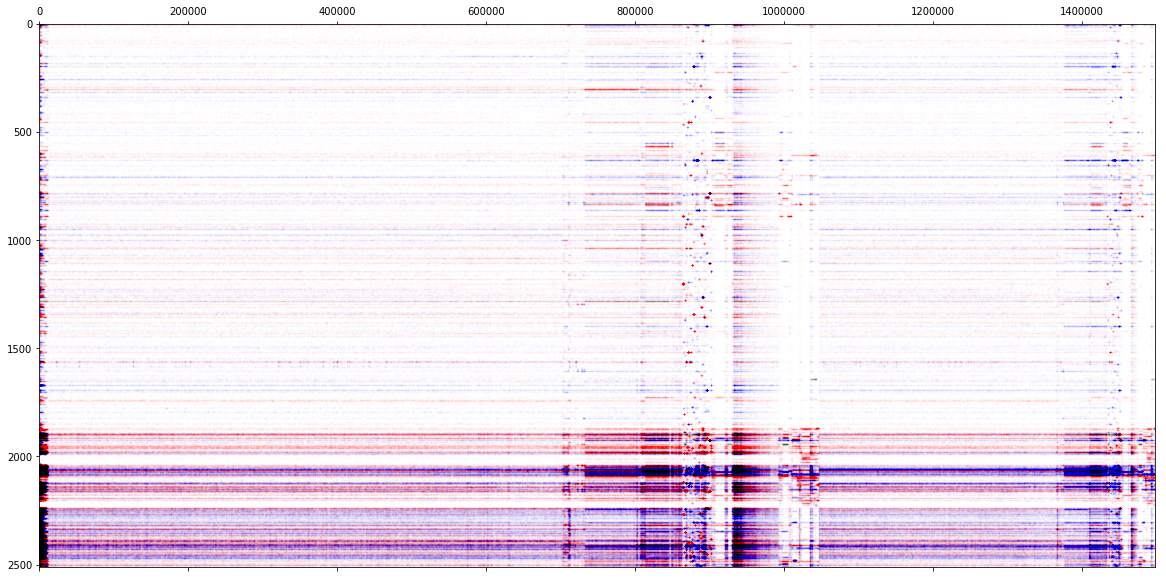

matrix density 0.000790


In [0]:
# Create scipy sparse matrix and visualize all years together in spyplot

density_numerator = 0

plt.subplots(figsize=(20,10))
colors = {100:'blue', 200:'red', 328:'green'}

for i in df['recipient.party'].unique():
  party_df = df[df['recipient.party'] == i]
  row = party_df['bonica.cid'].astype(contributors).cat.codes
  col = party_df['bonica.rid'].astype(recipients).cat.codes

  sparse_matrix = csr_matrix((np.log(party_df["amount"]), (row, col)), \
                         shape=(contributors.categories.size, recipients.categories.size))

  density_numerator += sparse_matrix.size 
  plt.spy(sparse_matrix.transpose(), marker='.', markersize=2.5, aspect='auto', color=colors[i], alpha=0.002)

plt.show()


shape = sparse_matrix.get_shape()

print('matrix density %f' %(float(density_numerator) / (shape[0]*shape[1])))

In [0]:
df['recipient.party'].value_counts()

200.0    2507680
100.0    2488515
328.0      28251
Name: recipient.party, dtype: int64

1980


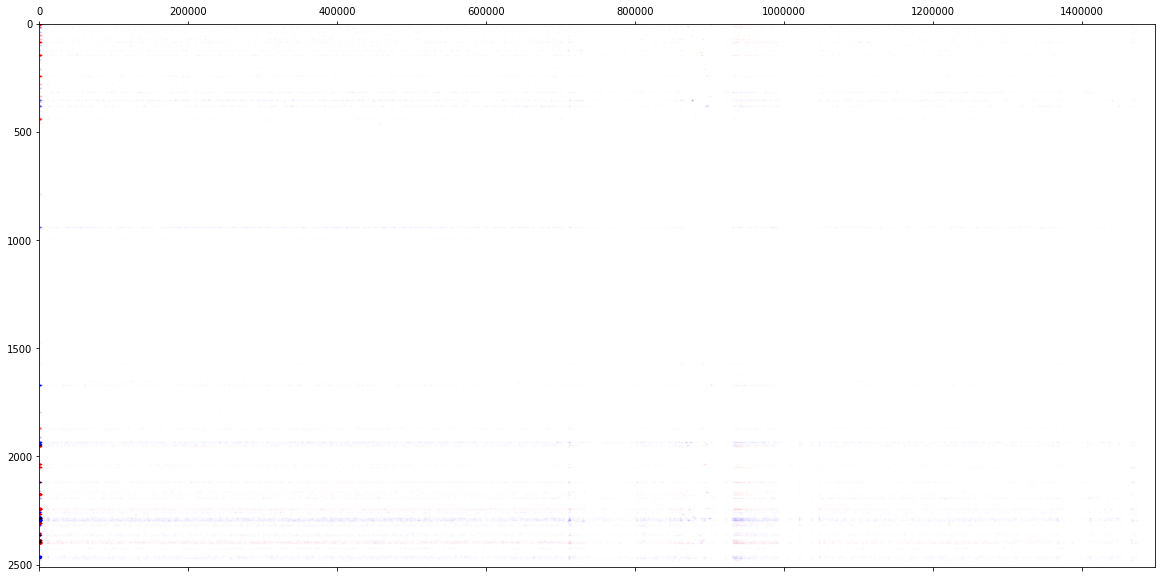

matrix density 0.000015 
 

1982


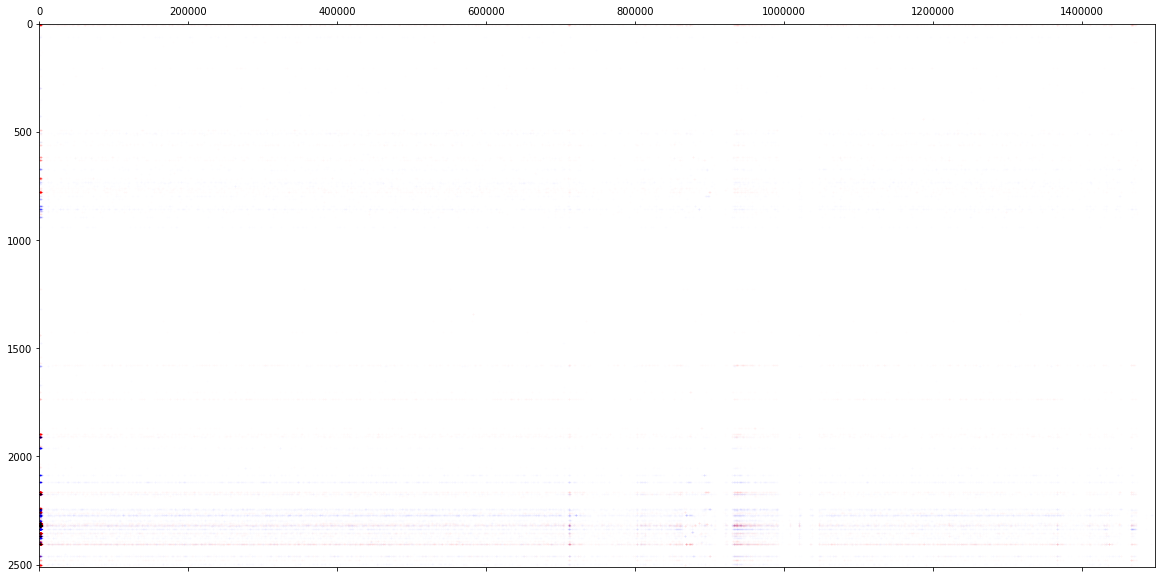

matrix density 0.000016 
 

1984


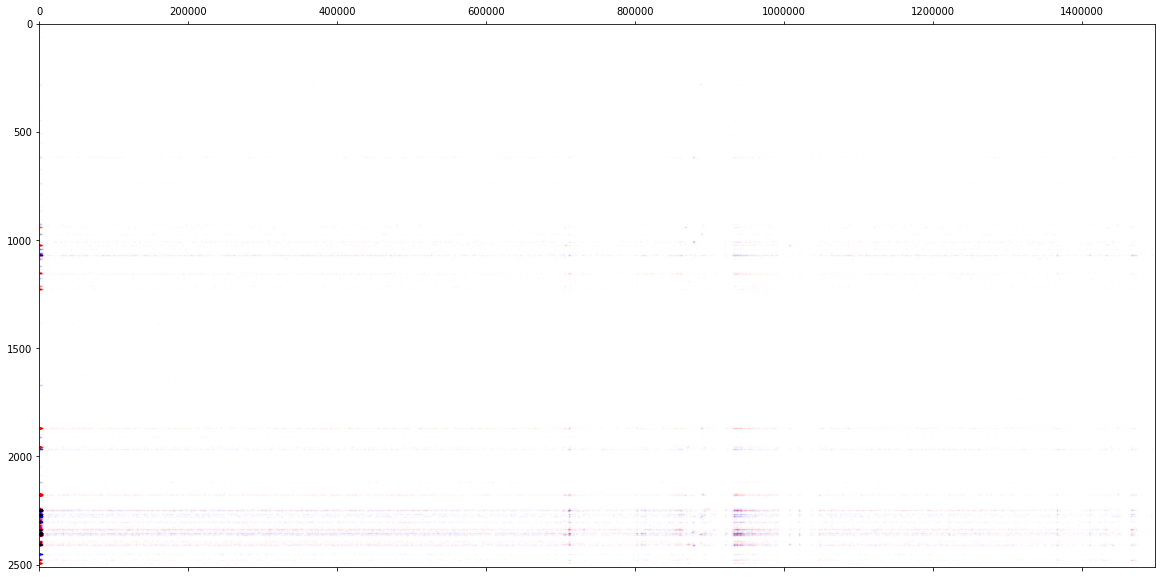

matrix density 0.000020 
 

1986


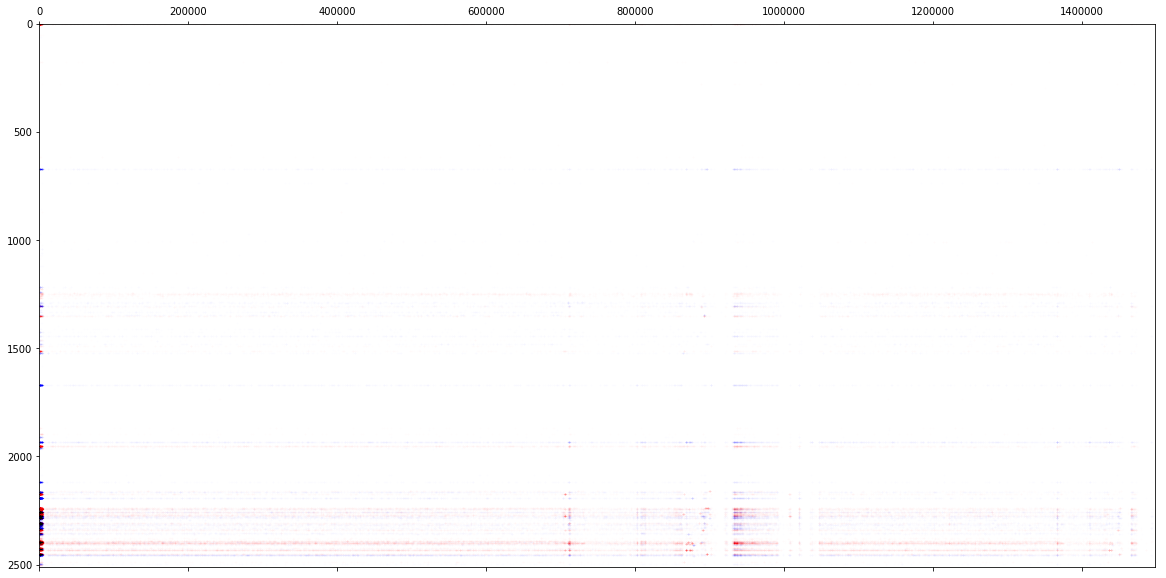

matrix density 0.000030 
 

1988


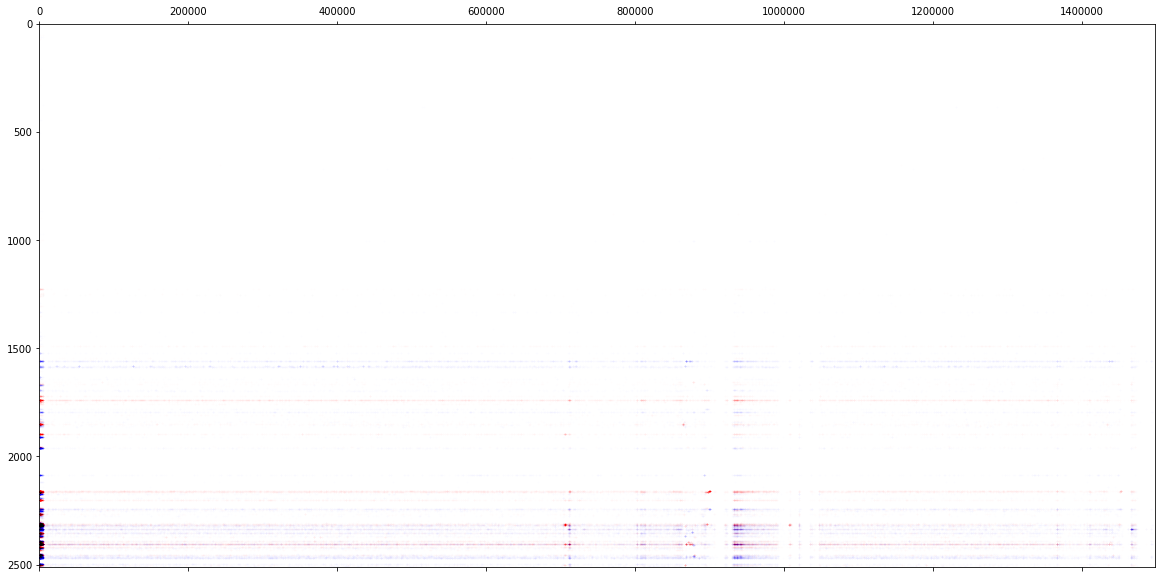

matrix density 0.000030 
 

1990


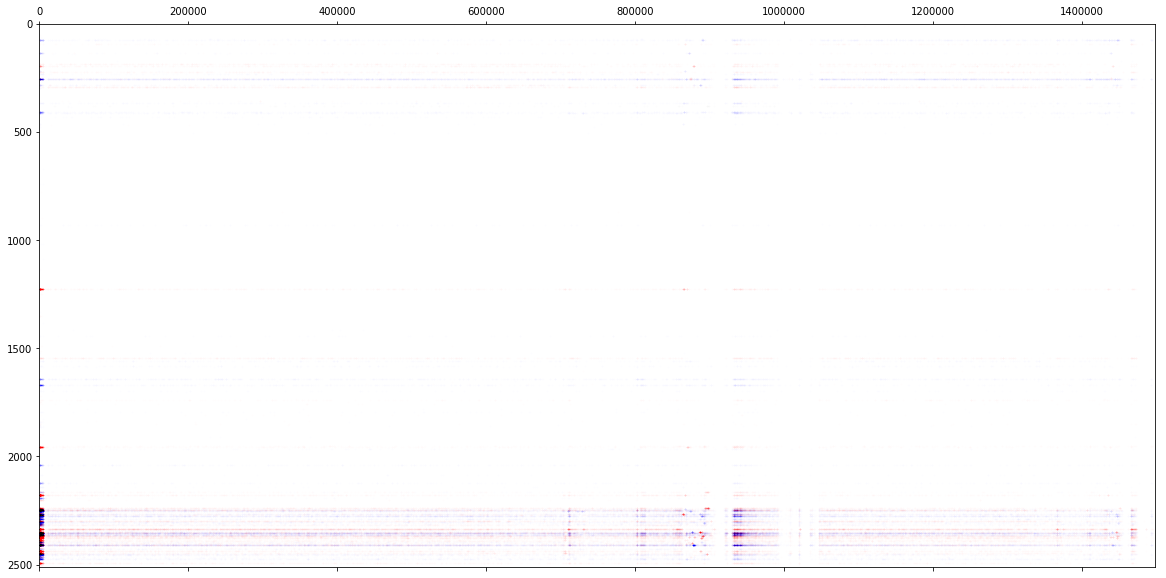

matrix density 0.000036 
 

1992


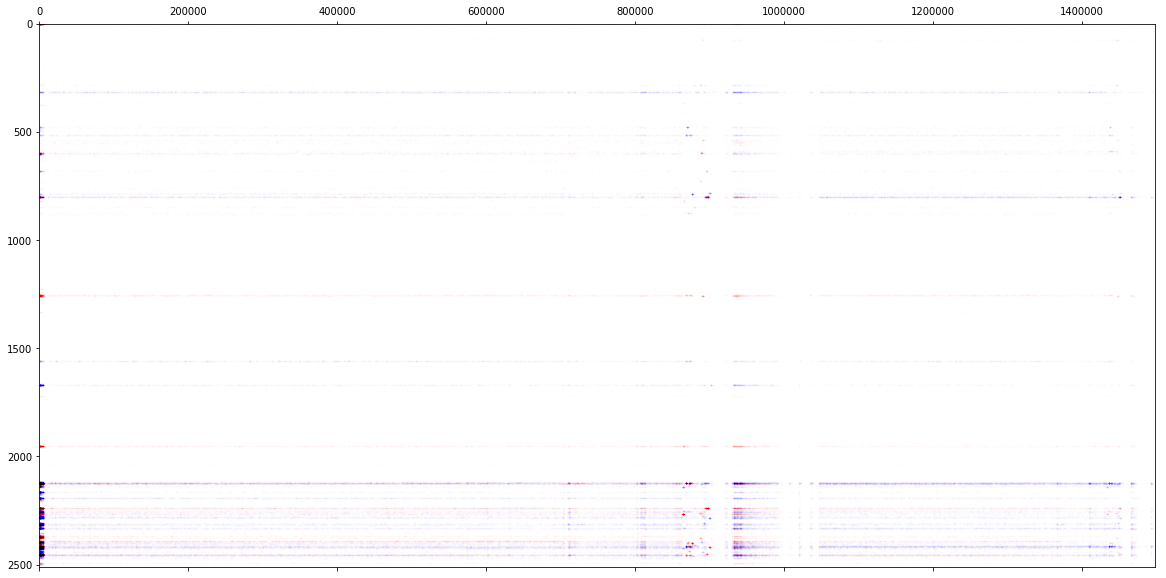

matrix density 0.000047 
 

1994


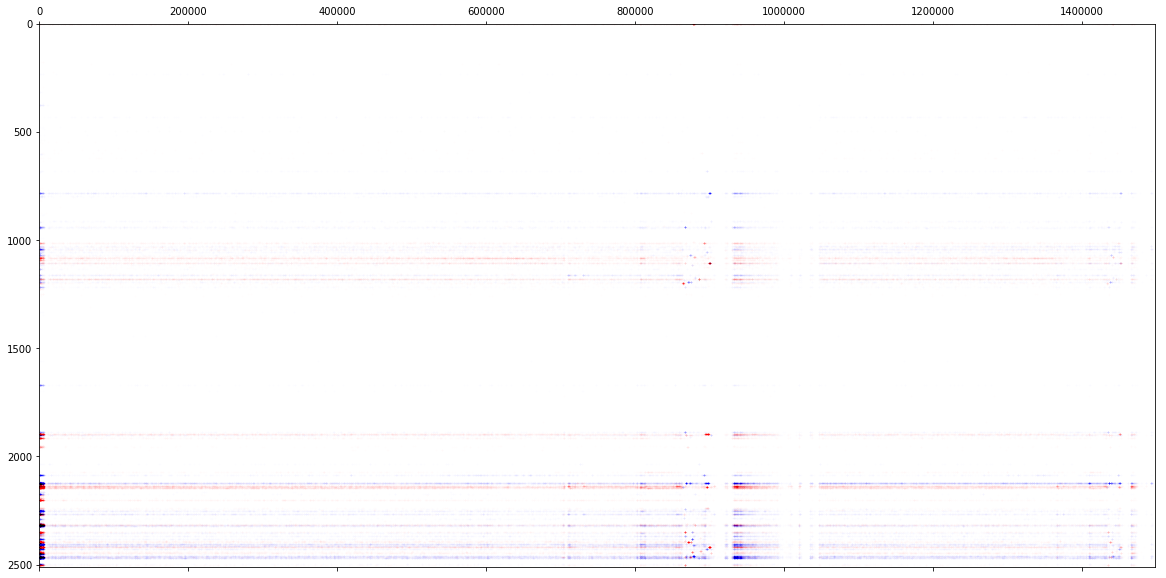

matrix density 0.000052 
 

1996


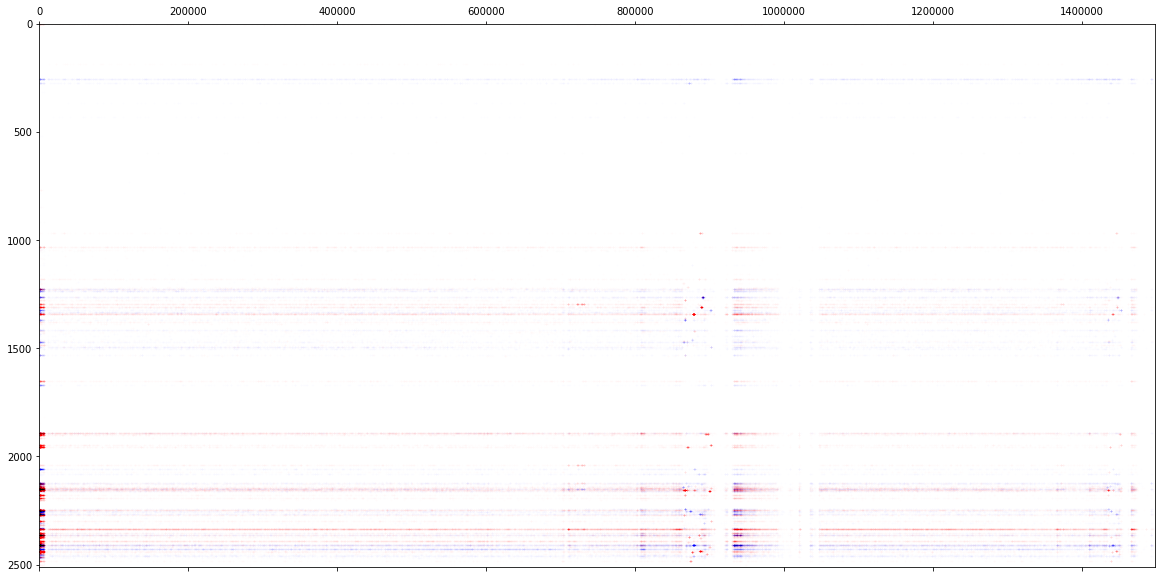

matrix density 0.000054 
 

1998


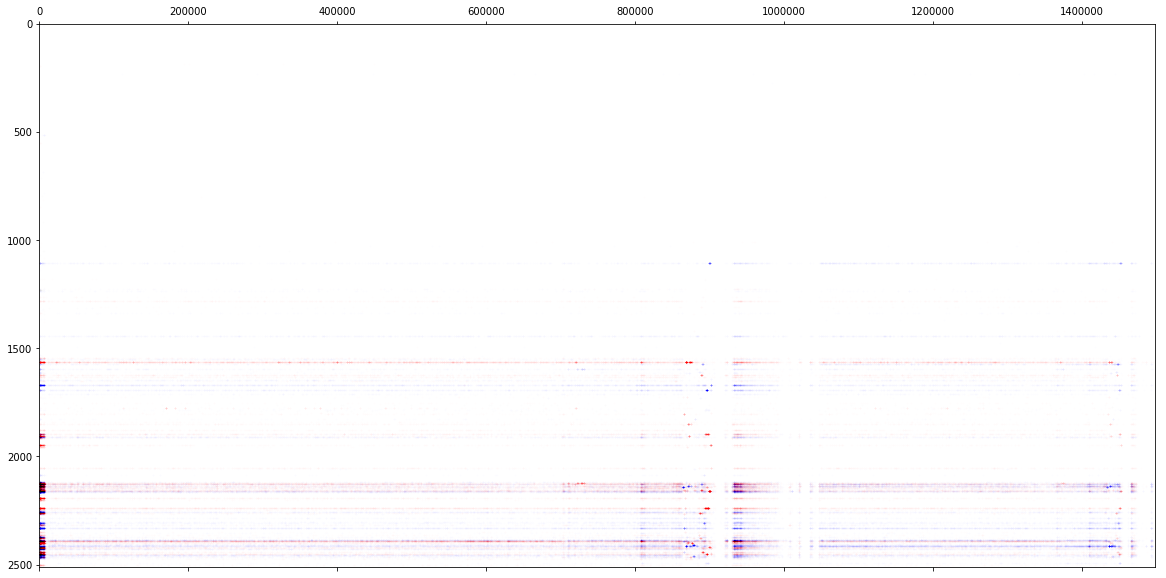

matrix density 0.000051 
 

2000


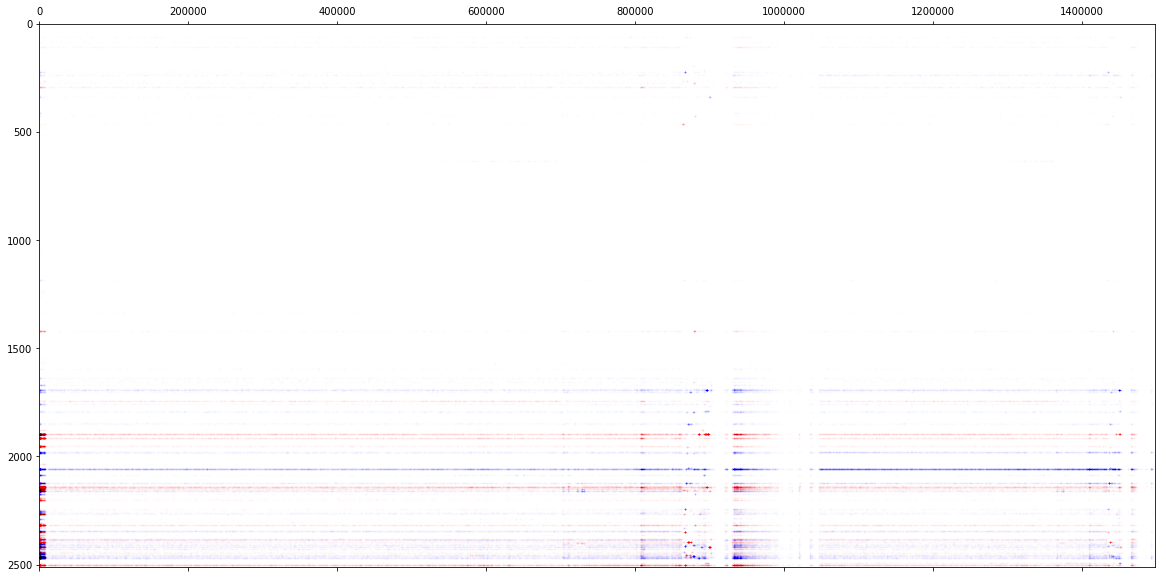

matrix density 0.000063 
 

2002


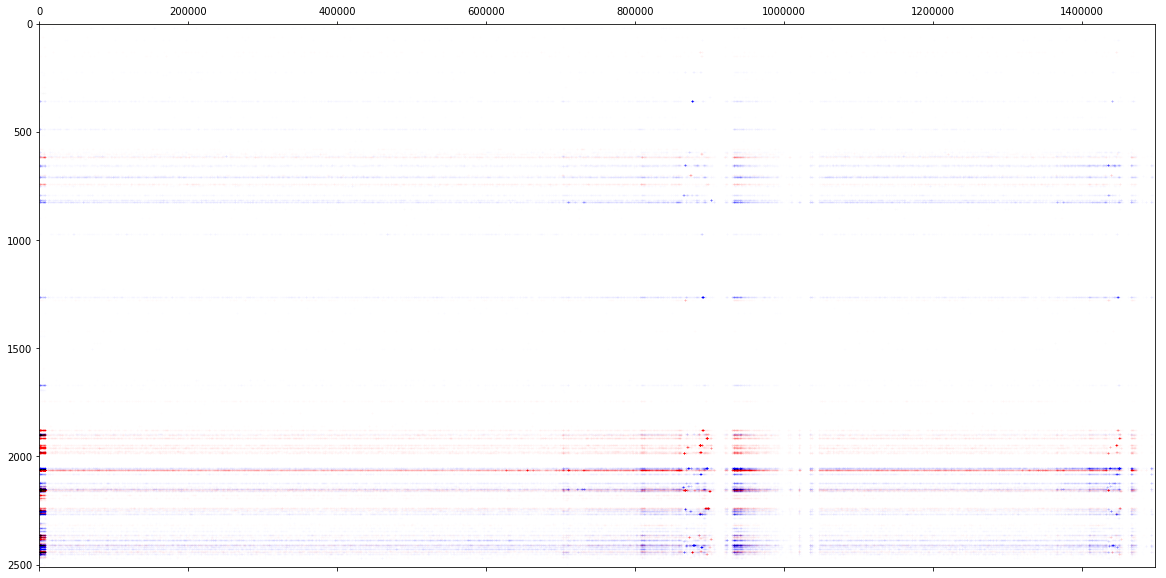

matrix density 0.000067 
 

2004


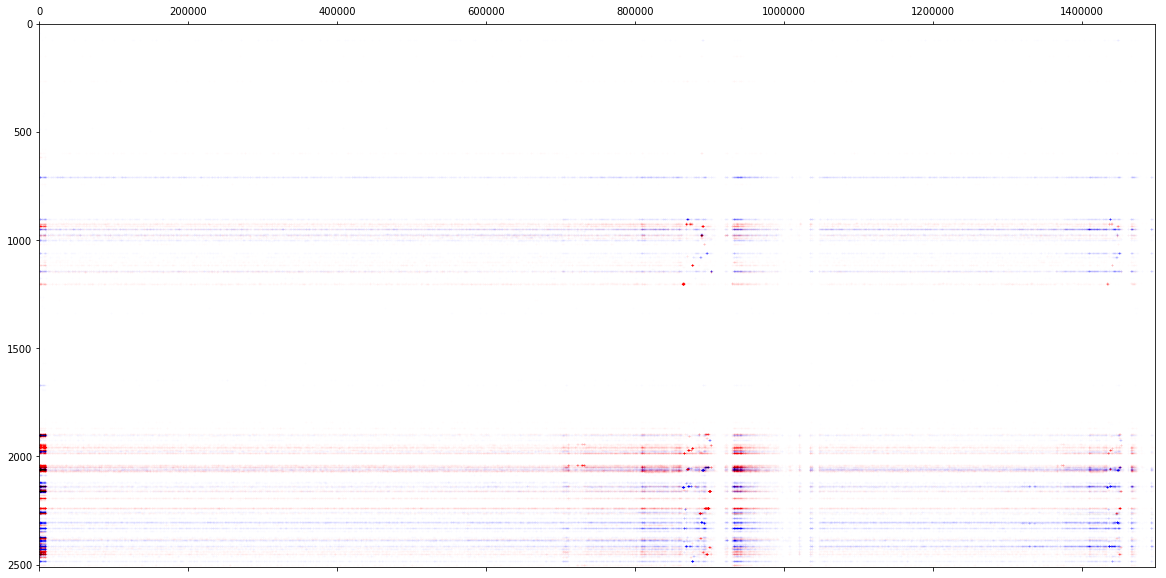

matrix density 0.000077 
 

2006


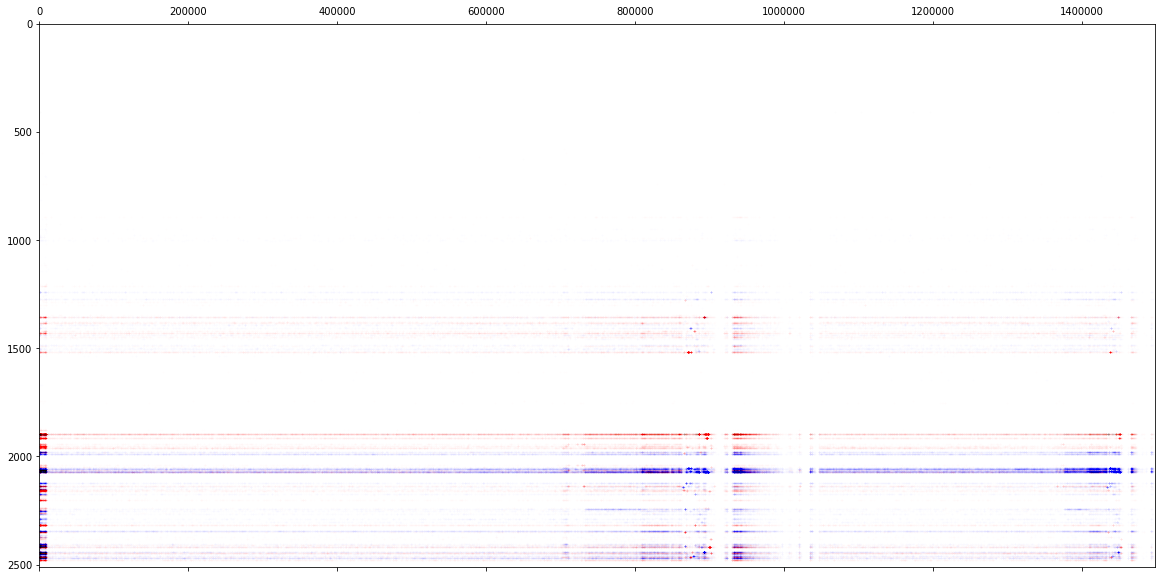

matrix density 0.000077 
 

2008


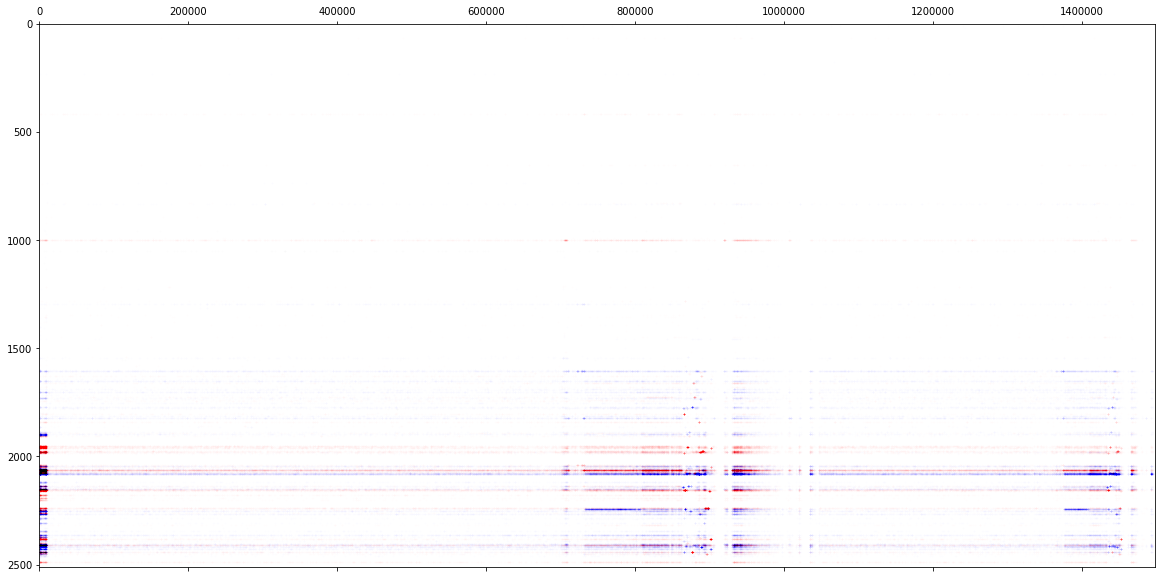

matrix density 0.000061 
 

2010


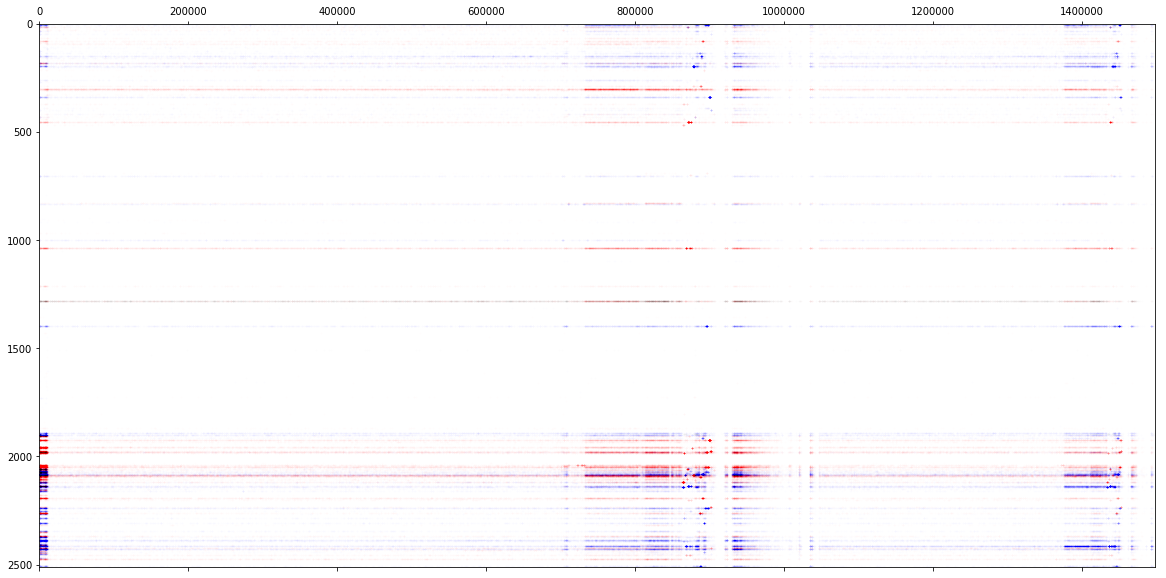

matrix density 0.000092 
 

2012


matrix density 0.000080 
 

2014


matrix density 0.000068 
 



In [0]:
# Visualize each year as separate spy plot & calculate matrix density 

for j in df['cycle'].unique():
    
    density_numerator = 0
    
    print(j)
    year_df = df[df['cycle'] == j]
    
    plt.subplots(figsize=(20,10))
    colors = {100:'blue', 200:'red', 328:'green'}

    for i in year_df['recipient.party'].unique():
      party_df = year_df[year_df['recipient.party'] == i]
      row = party_df['bonica.cid'].astype(contributors).cat.codes
      col = party_df['bonica.rid'].astype(recipients).cat.codes

      sparse_matrix = csr_matrix((np.log(party_df["amount"]), (row, col)), \
                             shape=(contributors.categories.size, recipients.categories.size))

      density_numerator += sparse_matrix.size 
      
      plt.spy(sparse_matrix.transpose(), marker='.', markersize=2.5, aspect='auto', color=colors[i], alpha=0.002)

    plt.show()
    
    shape = sparse_matrix.get_shape()

    print('matrix density %f \n \n' %(float(density_numerator) / (shape[0]*shape[1])))

# Use NetworkX to construct alternate graph - Adacency & Laplacian matrices 

In [0]:
import networkx as nx

G = nx.Graph()

for candidate, contributor, amount in zip(df['bonica.rid'], df['bonica.cid'], df['amount']):
  G.add_edge(contributor, candidate, weight=amount)

In [0]:
G.size()

2971402

In [0]:
A = nx.adjacency_matrix(G)

In [0]:
L = nx.laplacian_matrix(G)

# SVD on sparse weighted adjacency matrix (for all years)

In [0]:
# Recreate sparse matrix will data for all years

row = df['bonica.cid'].astype(contributors).cat.codes
col = df['bonica.rid'].astype(recipients).cat.codes

sparse_matrix = csr_matrix((np.log(df["amount"]), (row, col)), \
                       shape=(contributors.categories.size, recipients.categories.size))

In [0]:
from scipy.sparse.linalg import svds

u, s, vt = svds(sparse_matrix, k=200)

In [9]:
# The 200 chosen singular values (flipped so in descending order)

np.flip(s)

array([12391.36864594,  8635.93846175,  6493.46169308,  4865.1190334 ,
        4238.70857492,  4139.53928663,  3871.02639195,  3829.20256613,
        3671.68511145,  3502.38173453,  3493.73254872,  3401.2396879 ,
        3303.32283592,  3198.37121662,  3122.62352542,  2985.51230686,
        2949.90418183,  2873.9393226 ,  2827.24999323,  2797.11792568,
        2784.99440113,  2772.79829805,  2706.56643458,  2654.88965088,
        2628.44951514,  2619.93155585,  2608.21838691,  2524.66387517,
        2507.15233061,  2477.09161325,  2465.18005183,  2434.47972767,
        2410.08307885,  2395.55835576,  2387.8226431 ,  2375.95129229,
        2348.23341748,  2307.71728851,  2283.06598391,  2252.36913167,
        2216.77213016,  2197.14235731,  2188.23704883,  2135.35749838,
        2093.09079496,  2080.66853793,  2078.08014595,  2073.75777098,
        2060.76253829,  2049.27652096,  2023.63159286,  2003.80619229,
        2000.95316113,  1971.97008974,  1953.42634842,  1932.93798797,
      

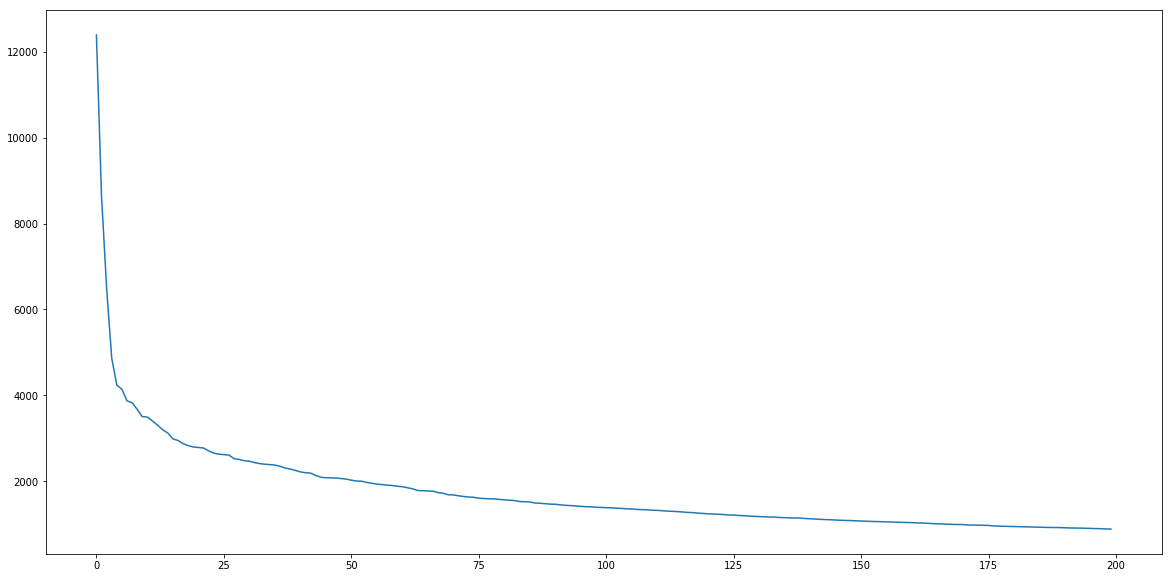

In [0]:
# Visualize magnitude of singular values

plt.figure(figsize=(20,10))
plt.plot(np.flip(s))

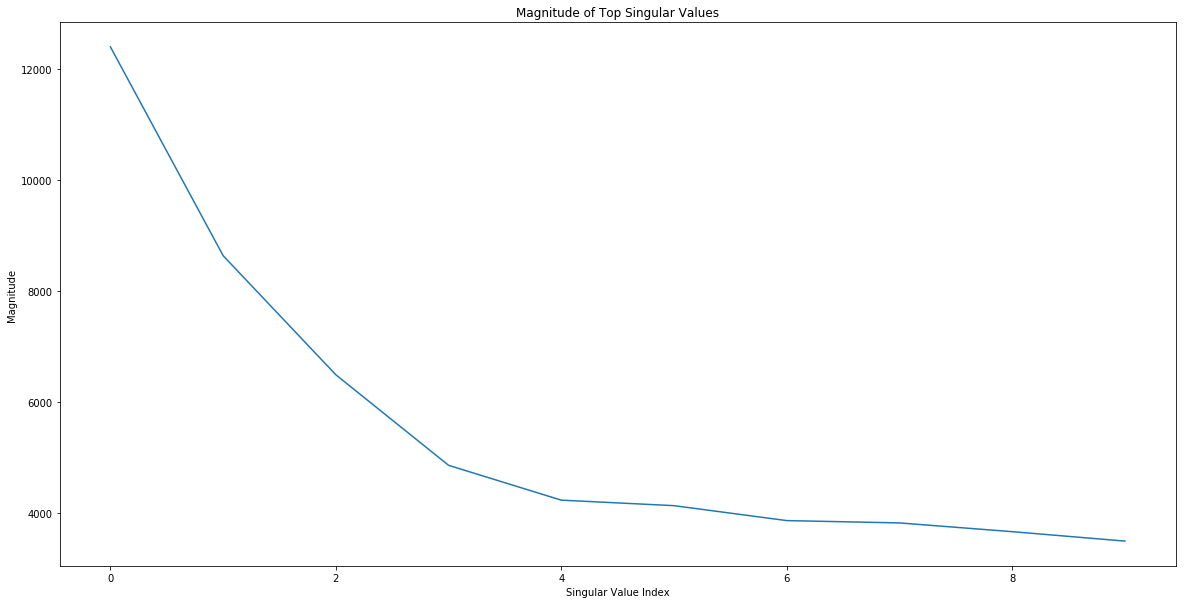

In [0]:

plt.figure(figsize=(20,10))
plt.title('Magnitude of Top Singular Values')
plt.ylabel('Magnitude')
plt.xlabel('Singular Value Index')
plt.plot(np.flip(s)[:10])

In [0]:
# Eigenvectors and thus "weights" associated with contributors

u.shape

(1498952, 200)

In [0]:
# Eigenvectors and thus "weights" associated with candidate recipients

vt.shape

(200, 2513)

In [0]:
candidate_lookup = df[['bonica.rid', 'recipient.name', 'recipient.party']].groupby('bonica.rid').agg({'recipient.name':'first', 'recipient.party':'first'}).reset_index()

In [0]:
candidate_lookup = candidate_lookup.sort_values(by='bonica.rid')

In [0]:
candidate_lookup.head()

bonica.rid         recipient.name  recipient.party
0      cand10           DOLE, ROBERT            200.0
1  cand100440         ROMNEY, W MITT            200.0
2  cand100450         HUCKABEE, MIKE            200.0
3  cand100628  BARBOUR, HALEY REEVES            200.0
4    cand1008    SESTAK, JOSEPH A JR            100.0

In [0]:
cand_svd_df = pd.DataFrame(vt.transpose())
#cand_svd_df['cand'] = sorted(df['bonica.rid'].unique())
cand_svd_df['cand'] = candidate_lookup['recipient.name']
cand_svd_df['party'] = candidate_lookup['recipient.party']

In [0]:
top_svd_df = cand_svd_df[['cand', 'party', 197, 198, 199]]
#top_svd_df = top_svd_df.set_index('cand')


In [0]:
from mpl_toolkits.mplot3d import axes3d, Axes3D

fig = plt.figure(figsize=(30, 10))
t = fig.suptitle('viz', fontsize=14)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 115)

xs = list(top_svd_df[197])
ys = list(top_svd_df[198])
zs = list(top_svd_df[199])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]
colors = ['red' if int(pt) == 200 else ('blue' if int(pt) == 100 else 'yellow') for pt in list(top_svd_df['party'])]
names = list(top_svd_df['cand'])

for data, color, name in zip(data_points, colors, names):
    x, y, z = data
    ax.scatter(x, y, z, alpha=0.4, c=color, edgecolors='none', s=30)
    ax.text(x, y, z, name) 
    
ax.set_xlabel('sv3')
ax.set_ylabel('sv2')
ax.set_zlabel('sv1')

Text(0.5, 0, 'sv1')

Text(0.5, 0, 'sv1')

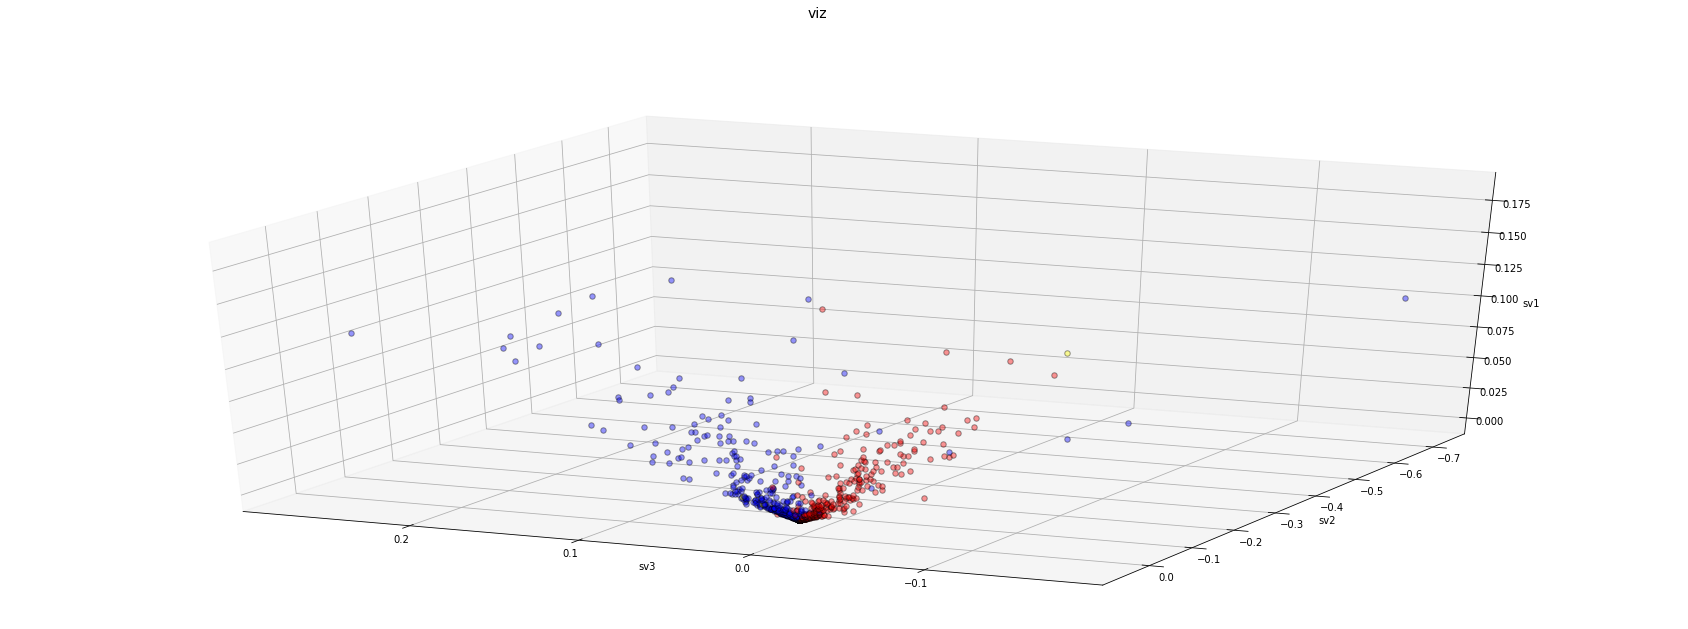

In [0]:
# Try with no text

from mpl_toolkits.mplot3d import axes3d, Axes3D

fig = plt.figure(figsize=(30, 10))
t = fig.suptitle('viz', fontsize=14)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 115)

xs = list(top_svd_df[197])
ys = list(top_svd_df[198])
zs = list(top_svd_df[199])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]
colors = ['red' if int(pt) == 200 else ('blue' if int(pt) == 100 else 'yellow') for pt in list(top_svd_df['party'])]
names = list(top_svd_df['cand'])

for data, color, name in zip(data_points, colors, names):
    x, y, z = data
    ax.scatter(x, y, z, alpha=0.4, c=color, edgecolors='none', s=30)
    #ax.text(x, y, z, name) 
    
ax.set_xlabel('sv3')
ax.set_ylabel('sv2')
ax.set_zlabel('sv1')

## Run same visualization for contributors

In [0]:
contributor_lookup = df[['bonica.cid', 'contributor.name', 'recipient.party']].groupby('bonica.cid').agg({'contributor.name':'first', 'recipient.party':'mean'}).reset_index()

In [0]:
contributor_lookup = contributor_lookup.sort_values(by='bonica.cid')

In [0]:
cont_svd_df = pd.DataFrame(u)
cont_svd_df['contributor'] = contributor_lookup['contributor.name']
cont_svd_df['most_frequent_candidate_party'] = contributor_lookup['recipient.party']

In [30]:
cont_svd_df.head()

0         1         2         3         4         5         6  \
0  0.000254 -0.000055  0.000307  0.001133  0.000508  0.000303  0.000271   
1  0.000088  0.000152  0.000147  0.000154 -0.000406 -0.000320 -0.000202   
2 -0.000845  0.002236 -0.002395 -0.011595  0.000521  0.004231 -0.004636   
3  0.001760  0.002515  0.010582  0.022731 -0.006596  0.001806  0.006742   
4 -0.003583 -0.019476  0.021847  0.022380 -0.015822 -0.001611  0.003918   

          7         8         9  ...       192       193       194       195  \
0 -0.000755 -0.000591  0.000447  ... -0.000042 -0.000035  0.000037 -0.000054   
1 -0.000004  0.000275 -0.000160  ...  0.000116  0.000017 -0.000153  0.000097   
2  0.003080 -0.000336 -0.003831  ... -0.001935 -0.000997  0.002504 -0.003173   
3  0.006811  0.000485  0.000746  ... -0.000042 -0.000467 -0.005311  0.000120   
4  0.008529  0.003812  0.001729  ... -0.001626 -0.000730  0.001737 -0.001274   

        196       197       198       199  \
0  0.000059  0.000058  0.000007  0.000035   
1 -0.000061 -0.000074  0.000015  0.000033   
2  0.003027  0.003182  0.000579  0.002790   
3 -0.003183 -0.013676  0.003452  0.007820   
4  0.003144 -0.015260  0.005658  0.015742   

                                         contributor  \
0                                UFWA COPE COMMITTEE   
1                                       jay, william   
2  INTERNATIONAL CHIROPRACTORS POLITICAL ACTION C...   
3  ILLINOIS TOOL WORKS INC. POLITICAL ACTION COMM...   
4  HALLMARK POLITICAL ACTION COMMITTEE FEDERAL HA...   

   most_frequent_candidate_party  
0                     100.000000  
1                     200.000000  
2                     120.754717  
3                     193.537415  
4                     177.045455  

[5 rows x 202 columns]

In [0]:
top_cont_svd_df = cont_svd_df[['contributor', 'most_frequent_candidate_party', 197, 198, 199]].sample(100000)

Text(0.5, 0, 'sv1')

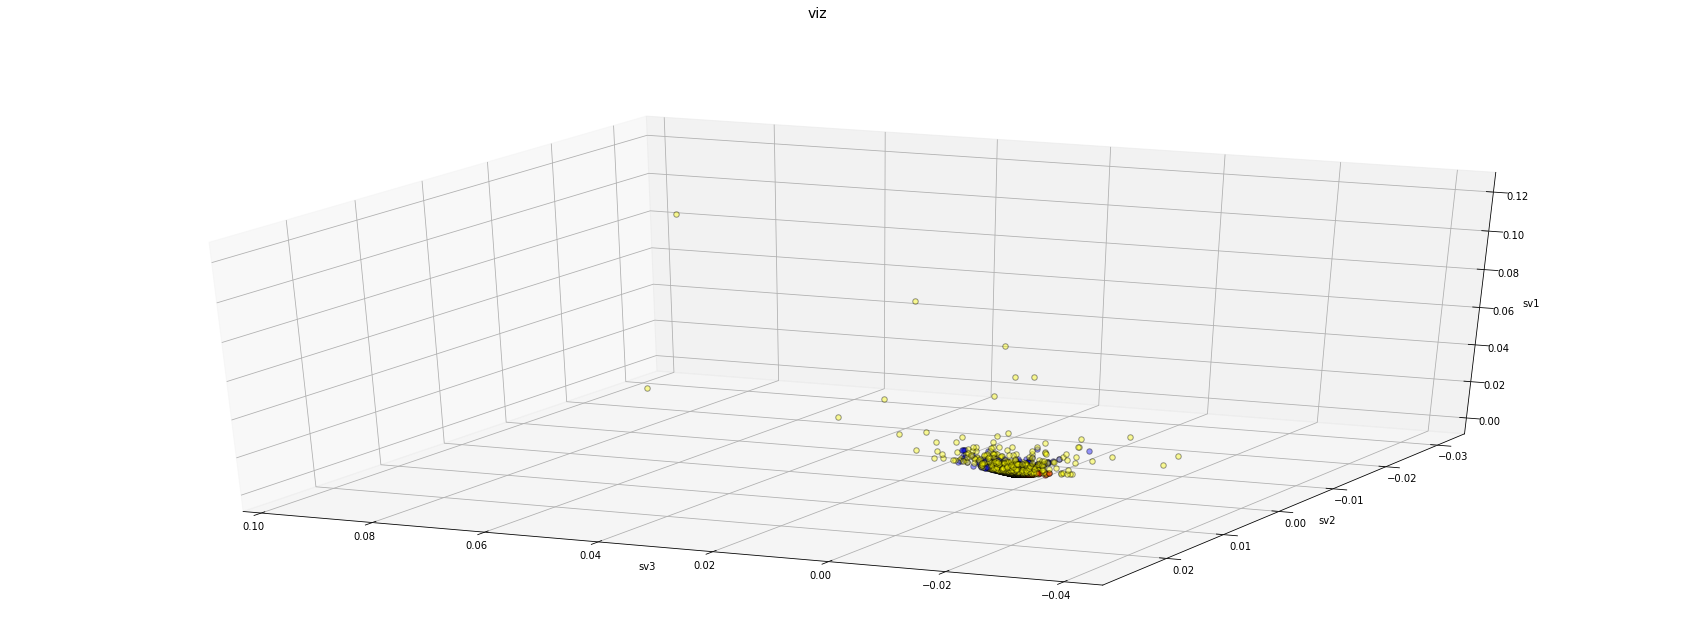

In [32]:
# Plot 3d scatterplot for contributor singular value weights

from mpl_toolkits.mplot3d import axes3d, Axes3D

fig = plt.figure(figsize=(30, 10))
t = fig.suptitle('viz', fontsize=14)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 115)

xs = list(top_cont_svd_df[197])
ys = list(top_cont_svd_df[198])
zs = list(top_cont_svd_df[199])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]
colors = ['red' if int(pt) == 200 else ('blue' if int(pt) == 100 else 'yellow') for pt in list(top_cont_svd_df['most_frequent_candidate_party'])]
names = list(top_cont_svd_df['contributor'])

for data, color, name in zip(data_points, colors, names):
    x, y, z = data
    ax.scatter(x, y, z, alpha=0.4, color=color, edgecolors='none', s=30)
    #ax.text(x, y, z, name) 
    
ax.set_xlabel('sv3')
ax.set_ylabel('sv2')
ax.set_zlabel('sv1')